# Standard HHMM

[This notebook](https://github.com/dattalab/state-moseq/blob/main/docs/source/standard_hhmm_tutorial.ipynb) contains code to simulate data from a standard hierarchical hidden Markov model (HHMM) and then fit a model to the simulated data. 

## 1. Create a model 

We'll start by creating a random model with 5 high-level states and 20 syllables. The model parameters consist of two tensors:
- `trans_probs`: transition probabilities between hidden states
- `emissions`: transition probabilities between syllables for each state

In [ ]:
from state_moseq.hhmm_standard import random_params
import matplotlib.pyplot as plt
import jax.random as jr
import jax.numpy as jnp
import numpy as np

hypparams = {
    "n_states": 5,
    "emissions_beta": 1,
    "trans_beta": 1,
    "trans_kappa": 100,
    "n_syllables": 20,
}
simulation_params = random_params(jr.PRNGKey(0), hypparams)

## 2. Visualize model parameters

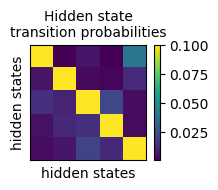

In [2]:
import matplotlib.pyplot as plt
plt.imshow(simulation_params["trans_probs"], vmax=0.1)
plt.colorbar()
plt.xlabel("hidden states")
plt.ylabel("hidden states")
plt.title('Hidden state\ntransition probabilities', fontsize=10)
plt.xticks([])
plt.yticks([])
plt.gcf().set_size_inches((2,1.5))

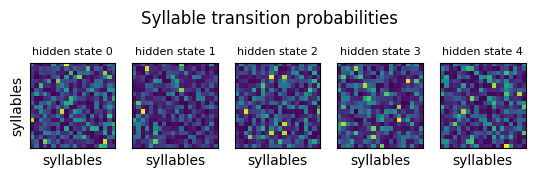

In [3]:
fig,axs = plt.subplots(1, hypparams["n_states"], sharey=True)
for i in range(hypparams["n_states"]):
    axs[i].imshow(simulation_params["emissions"][i])
    axs[i].set_xlabel("syllables")
    axs[i].set_xticks([])
    axs[i].set_title(f'hidden state {i}', fontsize=8)
axs[0].set_yticks([])
axs[0].set_ylabel("syllables")
fig.subplots_adjust(top=1.45)
fig.suptitle("Syllable transition probabilities");

## 3. Simulate data from model

Now let's generate fake data from the model. The simulation will first sample a sequence higher order states and then use those to generate a sequence of syllables. 

In [ ]:
from state_moseq.hhmm_standard import simulate

n_sequences = 200
n_timesteps = 1000

true_states, syllables = simulate(
    jr.PRNGKey(2), simulation_params, n_timesteps, n_sequences
)

### Visualize example "recording"

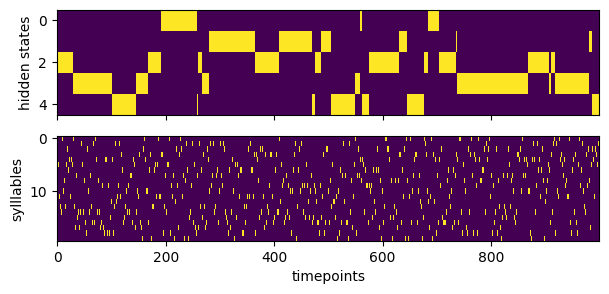

In [5]:
fig,axs = plt.subplots(2,1,sharex=True)
axs[0].imshow(np.eye(hypparams["n_states"])[true_states[0]].T, aspect='auto', interpolation='none')
axs[0].set_ylabel("hidden states")
axs[1].imshow(np.eye(hypparams["n_syllables"])[syllables[0]].T, aspect='auto', interpolation='none')
axs[1].set_ylabel("sylllables")
axs[1].set_xlabel("timepoints")
fig.set_size_inches((7,3))

## 4. Perform inference

Next we'll try to infer the model parameters from the simulated data using Gibbs sampling. Before inference, we have to generate a `data` dictionary that contains `syllables` and an array called `mask`. The purpose of `mask` is to indicate missing data in the `syllables` array and is useful when modeling sequences of uneven length. In our case there is no missing data so `mask` will be all 1's. 

In [ ]:
from state_moseq.hhmm_standard import initialize_params, fit_gibbs

data = {
    "syllables": syllables,
    "mask": jnp.ones_like(syllables),
}

# initial guess for parameters
init_params = initialize_params(data, hypparams, seed=jr.PRNGKey(3))

params, states, log_joints = fit_gibbs(
    data,
    hypparams,
    init_params,
    num_iters = 100)

100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 14.78it/s]


### Check for convergence

To make sure the model converged, we'll check for a plateau in the log joint probability

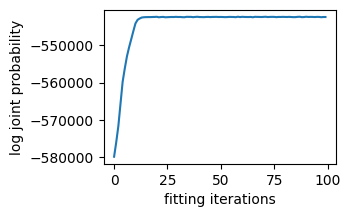

In [7]:
plt.plot(log_joints)
plt.ylabel('log joint probability')
plt.xlabel('fitting iterations')
plt.gcf().set_size_inches((3,2))

## 5. Inspect model fit

To compare true vs. inferred hidden states, the following code:
- Generates and plots a confusion matrix
- Calculates the accuracy, defined as the proportion of correctly classified timepoints (after permutation)

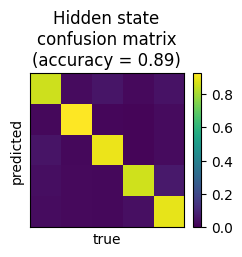

In [ ]:
from state_moseq import compare_states

confusion, permutation, accuracy = compare_states(states, true_states, hypparams["n_states"])

plt.imshow(confusion[permutation], vmin=0)
plt.colorbar()
plt.title(f'Hidden state\nconfusion matrix\n(accuracy = {round(accuracy.item(),2)})')
plt.xticks([])
plt.yticks([])
plt.ylabel("predicted")
plt.xlabel("true")
plt.gcf().set_size_inches((2.5,2))


## 6. Hidden state estimation

The `states` variable returned by `fit_gibbs` is the output of the final Gibbs sampling step. At best, this represents a random sample from the model's posterior distribution. In some cases, it may also be useful to estimate the maximum likelihood sequence of hidden states and/or the marginal distribution of hidden states at each timepoint. 

In [ ]:
from state_moseq.hhmm_standard import predicted_states, smoothed_states

maximum_likelihood_states = predicted_states(data, params)
marginal_probabilities = smoothed_states(data, params)

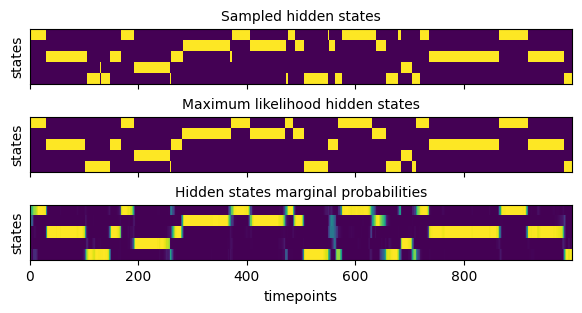

In [10]:
fig,axs = plt.subplots(3,1,sharex=True)
axs[0].imshow(np.eye(hypparams["n_states"])[states[0]].T, aspect='auto', interpolation='none')
axs[0].set_title("Sampled hidden states", fontsize=10)
axs[1].imshow(np.eye(hypparams["n_states"])[maximum_likelihood_states[0]].T, aspect='auto', interpolation='none')
axs[1].set_title("Maximum likelihood hidden states", fontsize=10)
axs[2].imshow(marginal_probabilities[0].T, aspect='auto', interpolation='none')
axs[2].set_title("Hidden states marginal probabilities", fontsize=10)
axs[2].set_xlabel("timepoints")
for ax in axs:
    ax.set_ylabel("states")
    ax.set_yticks([])
fig.subplots_adjust(hspace=.6)
fig.set_size_inches((7,3))